### Train Dense model

In [1]:
import os 
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import cv2
import keras

ROOT_DIR = os.path.abspath("../")

Using TensorFlow backend.


### Load data

In [2]:
# Load data
data = np.load(os.path.join(ROOT_DIR, "datasets", "beats_and_labels.npz"))
x_train = data['name1']
y_train = data['name2']
x_val = data['name3']
y_val = data['name4']
x_test = data['name5']
y_test = data['name6']

y_train = keras.utils.to_categorical(y_train, 2)
y_val = keras.utils.to_categorical(y_val, 2)
y_test = keras.utils.to_categorical(y_test, 2)

print(x_train.shape, y_train.shape)
print(x_val.shape, y_val.shape)
print(x_test.shape, y_test.shape)

(60051, 192) (60051, 2)
(23925, 192) (23925, 2)
(23628, 192) (23628, 2)


In [3]:
import keras
from keras.models import Sequential
from keras.layers import Dense, Flatten, Dropout
from keras.utils import to_categorical

model = Sequential()
model.add(Dense(32, activation = 'relu', input_dim = x_train.shape[1]))
model.add(Dropout(rate = 0.25))
model.add(Dense(2, activation = 'softmax'))

# compile the model
model.compile(loss='binary_crossentropy',
                optimizer = 'adam',
                metrics = ['accuracy'])

model.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_1 (Dense)              (None, 32)                6176      
_________________________________________________________________
dropout_1 (Dropout)          (None, 32)                0         
_________________________________________________________________
dense_2 (Dense)              (None, 2)                 66        
Total params: 6,242
Trainable params: 6,242
Non-trainable params: 0
_________________________________________________________________


In [4]:
# Define callbacks.
early_stopping_cb = keras.callbacks.EarlyStopping(monitor="val_loss", patience=10, restore_best_weights=True)

model.fit(x_train, y_train,
            validation_data=(x_val, y_val),
            batch_size = 512, 
            epochs= 1000, 
            verbose = 1,
            callbacks=[early_stopping_cb])

Train on 60051 samples, validate on 23925 samples
Epoch 1/1000
60051/60051 [==============================] - 1s 9us/step - loss: 0.4436 - accuracy: 0.8027 - val_loss: 0.2928 - val_accuracy: 0.9097
Epoch 2/1000
60051/60051 [==============================] - 0s 4us/step - loss: 0.2059 - accuracy: 0.9345 - val_loss: 0.2102 - val_accuracy: 0.9402
Epoch 3/1000
60051/60051 [==============================] - 0s 4us/step - loss: 0.1448 - accuracy: 0.9611 - val_loss: 0.1856 - val_accuracy: 0.9490
Epoch 4/1000
60051/60051 [==============================] - 0s 4us/step - loss: 0.1180 - accuracy: 0.9716 - val_loss: 0.1926 - val_accuracy: 0.9450
Epoch 5/1000
60051/60051 [==============================] - 0s 4us/step - loss: 0.1042 - accuracy: 0.9766 - val_loss: 0.1873 - val_accuracy: 0.9464
Epoch 6/1000
60051/60051 [==============================] - 0s 4us/step - loss: 0.0929 - accuracy: 0.9789 - val_loss: 0.1692 - val_accuracy: 0.9517
Epoch 7/1000
60051/60051 [==============================] - 0s

In [5]:
y_pred = model.predict(x_val,verbose = 1)

23925/23925 [==============================] - 0s 10us/step


In [6]:
def show_results(y, yhat):
    """
    y and yhat are 2D arrays of shape (N, 2)
    """
    # Flatten predictions
    yf = np.array([np.argmax(pred) for pred in y]) 
    yhatf = np.array([np.argmax(pred) for pred in yhat]) 
    
    from sklearn.metrics import accuracy_score
    # Accuracy
    acc = accuracy_score(yf, yhatf) * 100
    print("Accuracy : {:.2f}".format(acc))

    from sklearn.metrics import classification_report

    # Classification report
    target_names = ['0', '1']
    print("Classification report: ")
    print(classification_report(yf, yhatf, target_names=target_names, digits=4))
    
    #from sklearn.metrics import roc_auc_score
    #print('Area under ROC curve :{:.3f}'.format(roc_auc_score(y, yhat)))
    
    
    from sklearn.metrics import roc_curve, auc
    # https://github.com/hasibzunair/uniformizing-3D/blob/master/graph_compare.ipynb

    # Compute ROC curve and ROC area for each class
    fpr = dict()
    tpr = dict()
    roc_auc = dict()
    for i in range(2):
        fpr[i], tpr[i], _ = roc_curve(y[:, i], yhat[:, i])
        roc_auc[i] = auc(fpr[i], tpr[i])


    # Compute micro-average ROC curve and ROC area
    cls = 1 # class name
    fpr["micro"], tpr["micro"], _ = roc_curve(y.ravel(), yhat.ravel())
    roc_auc["micro"] = auc(fpr["micro"], tpr["micro"])

    #print(roc_auc)
    print("Area under the ROC curve for positive class: {:.3f}".format(roc_auc[cls]))
    
    plt.figure()
    lw = 2 # line width
    plt.plot(fpr[cls], tpr[cls], color='darkorange', lw=lw, label='ROC curve (area = {:.3f})'.format(roc_auc[cls]))
    plt.plot([0, 1], [0, 1], color='navy', lw=lw, linestyle='--')
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('Receiver operating characteristic example')
    plt.legend(loc="lower right")
    plt.show()


Accuracy : 96.99
Classification report: 
              precision    recall  f1-score   support

           0     0.9702    0.9874    0.9787     16777
           1     0.9691    0.9289    0.9486      7148

    accuracy                         0.9699     23925
   macro avg     0.9697    0.9581    0.9637     23925
weighted avg     0.9699    0.9699    0.9697     23925

Area under the ROC curve for positive class: 0.982


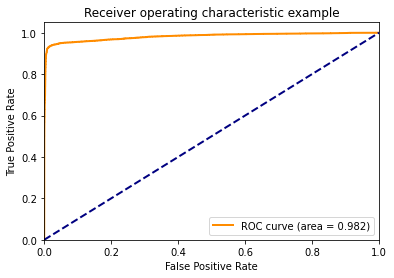

In [7]:
show_results(y_val, y_pred)

In [8]:
y_pred = model.predict(x_test,verbose = 1)
show_results(y_test, y_pred)

23628/23628 [==============================] - 0s 11us/step


In [13]:
from keras.layers import Conv1D

model = Sequential()
model.add(Conv1D(filters = 256, kernel_size = 5, activation = 'relu', input_shape = (192,1)))
model.add(Dropout(rate = 0.25))
model.add(Flatten())
model.add(Dense(2, activation = 'softmax'))

# compile the model - use categorical crossentropy, and the adam optimizer
model.compile(loss = 'binary_crossentropy',
                optimizer = 'adam',
                metrics = ['accuracy'])

model.summary()

Model: "sequential_3"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv1d_2 (Conv1D)            (None, 188, 256)          1536      
_________________________________________________________________
dropout_3 (Dropout)          (None, 188, 256)          0         
_________________________________________________________________
flatten_2 (Flatten)          (None, 48128)             0         
_________________________________________________________________
dense_4 (Dense)              (None, 2)                 96258     
Total params: 97,794
Trainable params: 97,794
Non-trainable params: 0
_________________________________________________________________


In [21]:
# Create batch axis 
x_train_cnn = np.reshape(x_train, (x_train.shape[0], x_train.shape[1], 1))
x_val_cnn = np.reshape(x_val, (x_val.shape[0], x_val.shape[1], 1))
x_test_cnn = np.reshape(x_test, (x_test.shape[0], x_test.shape[1], 1))

print(x_train_cnn.shape)
print(x_val_cnn.shape)
print(x_test_cnn.shape)

(60051, 192, 1)
(23925, 192, 1)
(23628, 192, 1)


In [19]:
# Define callbacks.
early_stopping_cb = keras.callbacks.EarlyStopping(monitor="val_loss", patience=10, restore_best_weights=True)

model.fit(x_train_cnn, y_train,
            validation_data=(x_val_cnn, y_val),
            batch_size = 512, 
            epochs= 1000, 
            verbose = 1,
            callbacks=[early_stopping_cb])

Train on 60051 samples, validate on 23925 samples
Epoch 1/1000
60051/60051 [==============================] - 1s 19us/step - loss: 0.0601 - accuracy: 0.9854 - val_loss: 0.2794 - val_accuracy: 0.9240
Epoch 2/1000
60051/60051 [==============================] - 1s 20us/step - loss: 0.0604 - accuracy: 0.9846 - val_loss: 0.3073 - val_accuracy: 0.9165
Epoch 3/1000
60051/60051 [==============================] - 1s 20us/step - loss: 0.0601 - accuracy: 0.9843 - val_loss: 0.2961 - val_accuracy: 0.9291
Epoch 4/1000
60051/60051 [==============================] - 1s 20us/step - loss: 0.0576 - accuracy: 0.9856 - val_loss: 0.2775 - val_accuracy: 0.9313
Epoch 5/1000
60051/60051 [==============================] - 1s 21us/step - loss: 0.0572 - accuracy: 0.9856 - val_loss: 0.4037 - val_accuracy: 0.8881
Epoch 6/1000
60051/60051 [==============================] - 1s 20us/step - loss: 0.0582 - accuracy: 0.9849 - val_loss: 0.2779 - val_accuracy: 0.9320
Epoch 7/1000
60051/60051 [==============================

23925/23925 [==============================] - 0s 19us/step
Accuracy : 94.27
Classification report: 
              precision    recall  f1-score   support

           0     0.9300    0.9930    0.9605     16777
           1     0.9805    0.8246    0.8958      7148

    accuracy                         0.9427     23925
   macro avg     0.9553    0.9088    0.9281     23925
weighted avg     0.9451    0.9427    0.9412     23925

Area under the ROC curve for positive class: 0.942


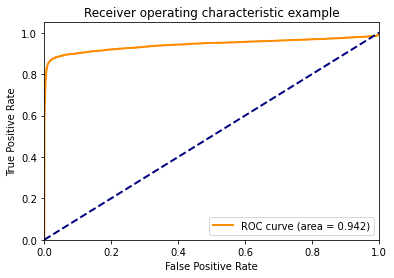

In [22]:
y_pred = model.predict(x_val_cnn, verbose = 1)
show_results(y_val, y_pred)

23628/23628 [==============================] - 0s 19us/step
Accuracy : 90.29
Classification report: 
              precision    recall  f1-score   support

           0     0.9591    0.9077    0.9327     17510
           1     0.7709    0.8893    0.8259      6118

    accuracy                         0.9029     23628
   macro avg     0.8650    0.8985    0.8793     23628
weighted avg     0.9104    0.9029    0.9050     23628

Area under the ROC curve for positive class: 0.938


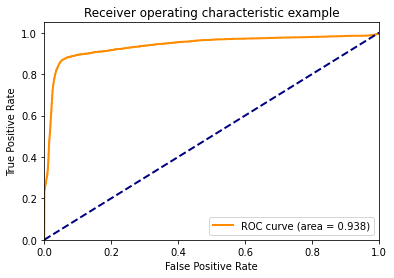

In [23]:
y_pred = model.predict(x_test_cnn, verbose = 1)
show_results(y_test, y_pred)

https://www.kaggle.com/gregoiredc/arrhythmia-on-ecg-classification-using-cnn

In [25]:
from keras.layers import Dense, Convolution1D, MaxPool1D, Flatten, Dropout
from keras.layers import Input
from keras.models import Model
from keras.layers.normalization import BatchNormalization
import keras
from keras.callbacks import EarlyStopping, ModelCheckpoint


def network():
    im_shape=(x_train_cnn.shape[1],1)
    inputs_cnn=Input(shape=(im_shape), name='inputs_cnn')
    conv1_1=Convolution1D(64, (6), activation='relu', input_shape=im_shape)(inputs_cnn)
    conv1_1=BatchNormalization()(conv1_1)
    pool1=MaxPool1D(pool_size=(3), strides=(2), padding="same")(conv1_1)
    conv2_1=Convolution1D(64, (3), activation='relu', input_shape=im_shape)(pool1)
    conv2_1=BatchNormalization()(conv2_1)
    pool2=MaxPool1D(pool_size=(2), strides=(2), padding="same")(conv2_1)
    conv3_1=Convolution1D(64, (3), activation='relu', input_shape=im_shape)(pool2)
    conv3_1=BatchNormalization()(conv3_1)
    pool3=MaxPool1D(pool_size=(2), strides=(2), padding="same")(conv3_1)
    flatten=Flatten()(pool3)
    dense_end1 = Dense(64, activation='relu')(flatten)
    dense_end2 = Dense(32, activation='relu')(dense_end1)
    main_output = Dense(2, activation='softmax', name='main_output')(dense_end2)
    
    model = Model(inputs= inputs_cnn, outputs=main_output)
    model.compile(optimizer='adam', loss='binary_crossentropy',metrics = ['accuracy'])
    
    return model


model = network()
model.summary()

Model: "model_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
inputs_cnn (InputLayer)      (None, 192, 1)            0         
_________________________________________________________________
conv1d_6 (Conv1D)            (None, 187, 64)           448       
_________________________________________________________________
batch_normalization_4 (Batch (None, 187, 64)           256       
_________________________________________________________________
max_pooling1d_4 (MaxPooling1 (None, 94, 64)            0         
_________________________________________________________________
conv1d_7 (Conv1D)            (None, 92, 64)            12352     
_________________________________________________________________
batch_normalization_5 (Batch (None, 92, 64)            256       
_________________________________________________________________
max_pooling1d_5 (MaxPooling1 (None, 46, 64)            0   

In [26]:
# Define callbacks.
early_stopping_cb = keras.callbacks.EarlyStopping(monitor="val_loss", patience=10, restore_best_weights=True)

model.fit(x_train_cnn, y_train,
            validation_data=(x_val_cnn, y_val),
            batch_size = 512, 
            epochs= 1000, 
            verbose = 1,
            callbacks=[early_stopping_cb])

Train on 60051 samples, validate on 23925 samples
Epoch 1/1000
60051/60051 [==============================] - 2s 37us/step - loss: 0.0825 - accuracy: 0.9713 - val_loss: 0.5883 - val_accuracy: 0.7037
Epoch 2/1000
60051/60051 [==============================] - 1s 22us/step - loss: 0.0280 - accuracy: 0.9924 - val_loss: 0.4746 - val_accuracy: 0.7492
Epoch 3/1000
60051/60051 [==============================] - 1s 23us/step - loss: 0.0220 - accuracy: 0.9939 - val_loss: 0.5645 - val_accuracy: 0.7806
Epoch 4/1000
60051/60051 [==============================] - 1s 22us/step - loss: 0.0182 - accuracy: 0.9947 - val_loss: 0.4134 - val_accuracy: 0.8513
Epoch 5/1000
60051/60051 [==============================] - 1s 24us/step - loss: 0.0148 - accuracy: 0.9954 - val_loss: 0.2485 - val_accuracy: 0.9037
Epoch 6/1000
60051/60051 [==============================] - 1s 21us/step - loss: 0.0141 - accuracy: 0.9959 - val_loss: 0.2007 - val_accuracy: 0.9299
Epoch 7/1000
60051/60051 [==============================

23925/23925 [==============================] - 1s 35us/step
Accuracy : 92.99
Classification report: 
              precision    recall  f1-score   support

           0     0.9394    0.9622    0.9506     16777
           1     0.9058    0.8542    0.8793      7148

    accuracy                         0.9299     23925
   macro avg     0.9226    0.9082    0.9149     23925
weighted avg     0.9293    0.9299    0.9293     23925

Area under the ROC curve for positive class: 0.970


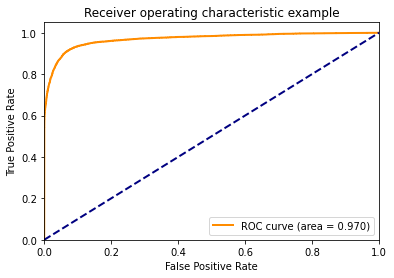

In [27]:
y_pred = model.predict(x_val_cnn, verbose = 1)
show_results(y_val, y_pred)

23628/23628 [==============================] - 1s 36us/step
Accuracy : 69.26
Classification report: 
              precision    recall  f1-score   support

           0     0.8545    0.7052    0.7727     17510
           1     0.4376    0.6564    0.5251      6118

    accuracy                         0.6926     23628
   macro avg     0.6461    0.6808    0.6489     23628
weighted avg     0.7466    0.6926    0.7086     23628

Area under the ROC curve for positive class: 0.782


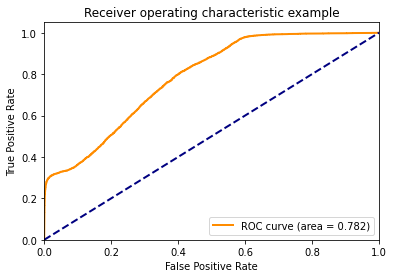

In [28]:
y_pred = model.predict(x_test_cnn, verbose = 1)
show_results(y_test, y_pred)

In [29]:
from keras.models import Model
from keras.layers import Input, Dense, Conv1D, MaxPooling1D, Add, Flatten, Activation
from keras import backend as K
from keras.optimizers import Adam


def network2():
    """Implementation of https://arxiv.org/pdf/1805.00794.pdf"""
    
    n_obs, feature, depth = x_train_cnn.shape
    
    inp = Input(shape=(feature, depth))
    C = Conv1D(filters=32, kernel_size=5, strides=1)(inp)

    C11 = Conv1D(filters=32, kernel_size=5, strides=1, padding='same')(C)
    A11 = Activation("relu")(C11)
    C12 = Conv1D(filters=32, kernel_size=5, strides=1, padding='same')(A11)
    S11 = Add()([C12, C])
    A12 = Activation("relu")(S11)
    M11 = MaxPooling1D(pool_size=5, strides=2)(A12)


    C21 = Conv1D(filters=32, kernel_size=5, strides=1, padding='same')(M11)
    A21 = Activation("relu")(C21)
    C22 = Conv1D(filters=32, kernel_size=5, strides=1, padding='same')(A21)
    S21 = Add()([C22, M11])
    A22 = Activation("relu")(S11)
    M21 = MaxPooling1D(pool_size=5, strides=2)(A22)


    C31 = Conv1D(filters=32, kernel_size=5, strides=1, padding='same')(M21)
    A31 = Activation("relu")(C31)
    C32 = Conv1D(filters=32, kernel_size=5, strides=1, padding='same')(A31)
    S31 = Add()([C32, M21])
    A32 = Activation("relu")(S31)
    M31 = MaxPooling1D(pool_size=5, strides=2)(A32)


    C41 = Conv1D(filters=32, kernel_size=5, strides=1, padding='same')(M31)
    A41 = Activation("relu")(C41)
    C42 = Conv1D(filters=32, kernel_size=5, strides=1, padding='same')(A41)
    S41 = Add()([C42, M31])
    A42 = Activation("relu")(S41)
    M41 = MaxPooling1D(pool_size=5, strides=2)(A42)


    C51 = Conv1D(filters=32, kernel_size=5, strides=1, padding='same')(M41)
    A51 = Activation("relu")(C51)
    C52 = Conv1D(filters=32, kernel_size=5, strides=1, padding='same')(A51)
    S51 = Add()([C52, M41])
    A52 = Activation("relu")(S51)
    M51 = MaxPooling1D(pool_size=5, strides=2)(A52)

    F1 = Flatten()(M51)

    D1 = Dense(32)(F1)
    A6 = Activation("relu")(D1)
    D2 = Dense(32)(A6)
    D3 = Dense(2, activation='softmax')(D2)

    model = Model(inputs=inp, outputs=D3)
    model.compile(optimizer='adam', loss='binary_crossentropy',metrics = ['accuracy'])
    
    return model

model = network2()
model.summary()

Model: "model_3"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            (None, 192, 1)       0                                            
__________________________________________________________________________________________________
conv1d_9 (Conv1D)               (None, 188, 32)      192         input_1[0][0]                    
__________________________________________________________________________________________________
conv1d_10 (Conv1D)              (None, 188, 32)      5152        conv1d_9[0][0]                   
__________________________________________________________________________________________________
activation_1 (Activation)       (None, 188, 32)      0           conv1d_10[0][0]                  
____________________________________________________________________________________________

In [30]:
# Define callbacks.
early_stopping_cb = keras.callbacks.EarlyStopping(monitor="val_loss", patience=10, restore_best_weights=True)

model.fit(x_train_cnn, y_train,
            validation_data=(x_val_cnn, y_val),
            batch_size = 512, 
            epochs= 1000, 
            verbose = 1,
            callbacks=[early_stopping_cb])

Train on 60051 samples, validate on 23925 samples
Epoch 1/1000
60051/60051 [==============================] - 2s 40us/step - loss: 0.1687 - accuracy: 0.9389 - val_loss: 0.2511 - val_accuracy: 0.8839
Epoch 2/1000
60051/60051 [==============================] - 1s 18us/step - loss: 0.0635 - accuracy: 0.9851 - val_loss: 0.1798 - val_accuracy: 0.9350
Epoch 3/1000
60051/60051 [==============================] - 1s 18us/step - loss: 0.0409 - accuracy: 0.9896 - val_loss: 0.2423 - val_accuracy: 0.9049
Epoch 4/1000
60051/60051 [==============================] - 1s 18us/step - loss: 0.0416 - accuracy: 0.9892 - val_loss: 0.1471 - val_accuracy: 0.9494
Epoch 5/1000
60051/60051 [==============================] - 1s 19us/step - loss: 0.0320 - accuracy: 0.9914 - val_loss: 0.2304 - val_accuracy: 0.9253
Epoch 6/1000
60051/60051 [==============================] - 1s 19us/step - loss: 0.0243 - accuracy: 0.9937 - val_loss: 0.2670 - val_accuracy: 0.9102
Epoch 7/1000
60051/60051 [==============================

23925/23925 [==============================] - 1s 35us/step
Accuracy : 94.94
Classification report: 
              precision    recall  f1-score   support

           0     0.9693    0.9583    0.9637     16777
           1     0.9046    0.9287    0.9165      7148

    accuracy                         0.9494     23925
   macro avg     0.9369    0.9435    0.9401     23925
weighted avg     0.9499    0.9494    0.9496     23925

Area under the ROC curve for positive class: 0.982


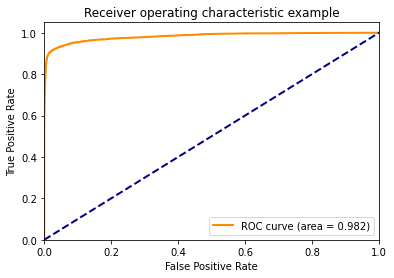

In [31]:
y_pred = model.predict(x_val_cnn, verbose = 1)
show_results(y_val, y_pred)

23628/23628 [==============================] - 1s 31us/step
Accuracy : 87.76
Classification report: 
              precision    recall  f1-score   support

           0     0.9660    0.8653    0.9129     17510
           1     0.7031    0.9127    0.7943      6118

    accuracy                         0.8776     23628
   macro avg     0.8345    0.8890    0.8536     23628
weighted avg     0.8979    0.8776    0.8822     23628

Area under the ROC curve for positive class: 0.911


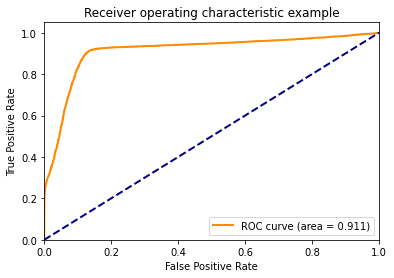

In [32]:
y_pred = model.predict(x_test_cnn, verbose = 1)
show_results(y_test, y_pred)